# Static network analysis


In [1]:
# System
from pathlib import Path    

# Data wrangling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Network analysis
import networkx as nx
import netbone as nb
import community

# Project specific
from src.config import cfg
from src.utils import data_explorer as dx
from src.utils import viz, nw_utils
from src.data_prep import data_prep
from src.analysis import sponsor_nw

# Misc
from IPython.display import display

%load_ext autoreload
%autoreload 2

Can't load ECM Model in windows, try using it on linux


## Load data


In [2]:
# Load data
data = data_prep.prepare_data()

# Focus on bills with policy area
data = data.dropna(subset=["policy_area"])

In [3]:
# Brief summary
dx.summarize_df(data)

Shape: (1666433, 18)


,bioguide_id,party,state,district,sponsor_type,congress,bill_type,bill_number,origin_chamber,policy_area,title,introduced_date,bill_id,sponsor_title,sponsor_id,first_name,last_name,display_name
0,Y000031,R,FL,10,sponsor,108,hjres,114,house,economics and public finance,Making further continuing appropriations for t...,2004-11-19,108_hjres_114,Rep,Y000031_R_FL_Rep,C. W.,Young,Rep. C. W. Young (R)


In [4]:
# Unique congresses
data["congress"].unique().tolist()

[108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118]

## Sample snapshot

- Limit the analysis to 108th congress in Senate


In [5]:
# Construct graphs
G_bip, G_proj, G_bone = sponsor_nw.create_static_network(
    data,
    congresses=[108],
    bill_types=["s"],
)

Marginal Likelihood Filter


## Initial visualization


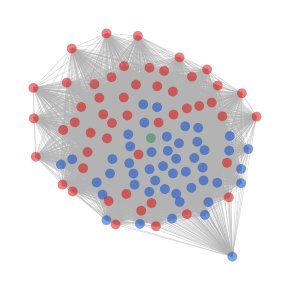

In [6]:
# Plot original projected network
node_colors = viz.nx_get_node_colors(G_proj, "party", cfg.cmap.PARTY)

fig, ax = plt.subplots(figsize=(3, 3))
viz.nx_plot_network(G_proj, ax=ax, node_color=node_colors)
plt.tight_layout()
plt.show()

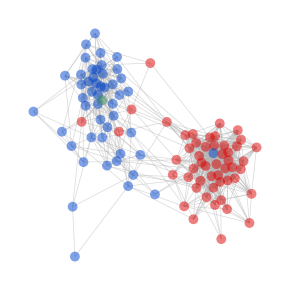

In [7]:
# Plot backbone network
node_colors = viz.nx_get_node_colors(G_bone, "party", cfg.cmap.PARTY)

fig, ax = plt.subplots(figsize=(3, 3))
viz.nx_plot_network(G_bone, ax=ax, node_color=node_colors)
plt.tight_layout()
plt.show()

## Summarize network


In [8]:
G_proj_summary = nw_utils.summarize_network(G_proj)
G_bone_summary = nw_utils.summarize_network(G_bone)

summary = pd.concat([G_proj_summary, G_bone_summary], ignore_index=True).round(2).T
summary.columns = ["G_proj", "G_bone"]
summary

,G_proj,G_bone
n_nodes,100,100
n_edges,4950,873
density,1.0,0.18
avg_degree,99.0,17.46
is_connected,True,True
n_cc,1,1
largest_cc,100,100
avg_clustering,1.0,0.5
transitivity,1.0,0.58
triangles,161700.0,3484.0


## Analyze polarization


In [9]:
dem_nodes = {n for n, d in G_bone.nodes(data=True) if d["party"] == "D"}
rep_nodes = {n for n, d in G_bone.nodes(data=True) if d["party"] == "R"}

G_dem = G_bone.subgraph(dem_nodes)
G_rep = G_bone.subgraph(rep_nodes)

print("Density (D): ", nx.density(G_dem))
print("Density (R): ", nx.density(G_rep))

Density (D):  0.25886524822695034
Density (R):  0.396078431372549


In [10]:
# Cross party edges
cross_party_edges = [
    (u, v)
    for u, v in G_bone.edges()
    if G_bone.nodes[u]["party"] != G_bone.nodes[v]["party"]
]

n_cross_party = len(cross_party_edges)

print("Cross-party edges: ", n_cross_party)
print("Cross-party edge density: ", n_cross_party / G_bone.number_of_edges())

Cross-party edges:  76
Cross-party edge density:  0.08705612829324169


In [11]:
# Community detection
partition = community.best_partition(G_bone)
modularity = community.modularity(partition, G_bone)
print("Modularity: ", modularity)

Modularity:  0.47211097914903605


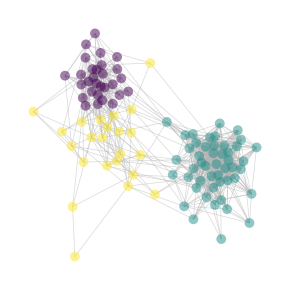

In [12]:
# Plot communities
fig, ax = plt.subplots(figsize=(3, 3))
viz.nx_plot_network(G_bone, ax=ax, node_color=partition.values())
plt.tight_layout()
plt.show()